In [1]:
!pip install pydot
!pip install pydotplus
!pip install graphviz

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 278 kB 869 kB/s eta 0:00:01
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24566 sha256=b6832de326df7fc3fa87b9f21efc1ffe0fdc065df5b4c3ff1099ba8647038779
  Stored in directory: /root/.cache/pip/wheels/1e/7b/04/7387cf6cc9e48b4a96e361b0be812f0708b394b821bf8c9c50
Successfully built pydotplus
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# 🌿 Cassava Disease Classification 🌿

In [2]:
import os
import glob
import random
import shutil
import warnings
import json
import itertools
import numpy as np
import pandas as pd
from collections import Counter

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from PIL import Image

from sklearn.model_selection import train_test_split

# Defining the working directories
work_dir = '../input/cassava-leaf-disease-classification/'
os.listdir(work_dir) 
train_path = '/kaggle/input/cassava-leaf-disease-classification/train_images'

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
with tf.device('/GPU:0'):
    print('Yes, there is GPU')
    
tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1
Yes, there is GPU


In [4]:
# Lets set all random seeds

def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 21
seed_everything(seed)
warnings.filterwarnings('ignore')

# 1. Data loading 📚

In [5]:
data = pd.read_csv(work_dir + 'train.csv')
print(data['label'].value_counts()) # Checking the frequencies of the labels

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64


In [6]:
# Importing the json file with labels
with open(work_dir + 'label_num_to_disease_map.json') as f:
    real_labels = json.load(f)
    real_labels = {int(k):v for k,v in real_labels.items()}
    
# Defining the working dataset
data['class_name'] = data['label'].map(real_labels)

real_labels

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

In [7]:
# generate train and test sets
train, test = train_test_split(data, test_size = 0.05, random_state = 42, stratify = data['class_name'])

In [8]:
IMG_SIZE = 456
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 5
BATCH_SIZE = 15

# 2. Data generator ⚙️

In [9]:
datagen_train = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest',
)

datagen_val = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
)


## Now, generate the new sets 

In [10]:
train_set = datagen_train.flow_from_dataframe(
    train,
    directory=train_path,
    seed=42,
    x_col='image_id',
    y_col='class_name',
    target_size = size,
    class_mode='categorical',
    interpolation='nearest',
    shuffle = True,
    batch_size = BATCH_SIZE,
)

test_set = datagen_val.flow_from_dataframe(
    test,
    directory=train_path,
    seed=42,
    x_col='image_id',
    y_col='class_name',
    target_size = size,
    class_mode='categorical',
    interpolation='nearest',
    shuffle=True,
    batch_size=BATCH_SIZE,    
)

Found 20327 validated image filenames belonging to 5 classes.
Found 1070 validated image filenames belonging to 5 classes.


# 3. Modeling part 🍻

In [11]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3

In [12]:
def create_model():
    
    model = Sequential()
    # initialize the model with input shape
    model.add(
        EfficientNetB3(
            input_shape = (IMG_SIZE, IMG_SIZE, 3), 
            include_top = False,
            weights='imagenet',
            drop_connect_rate=0.6,
        )
    )
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(
        256, 
        activation='relu', 
        bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)
    ))
    model.add(Dropout(0.5))
    model.add(Dense(n_CLASS, activation = 'softmax'))
    
    return model

leaf_model = create_model()
leaf_model.summary()

43941888/43941136 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 15, 15, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               393472    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 11,178,292
Trainable params: 11,090,989
Non

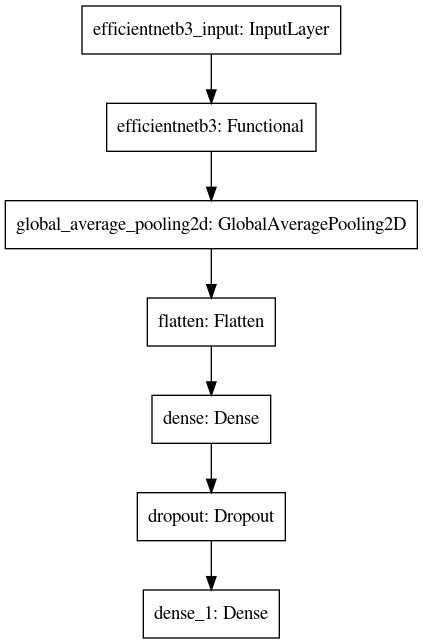

In [13]:
keras.utils.plot_model(leaf_model)

In [14]:
EPOCHS = 15
STEP_SIZE_TRAIN = train_set.n // train_set.batch_size
STEP_SIZE_TEST = test_set.n // test_set.batch_size

## Fit the model

In [15]:
def model_fit():
    leaf_model = create_model()
    
    # Loss function 
    # https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy
    loss = tf.keras.losses.CategoricalCrossentropy(
        from_logits = False,
        label_smoothing=0.0001,
        name='categorical_crossentropy'
    )
    
    # Compile the model
    leaf_model.compile(
        optimizer = Adam(learning_rate = 1e-3),
        loss = loss, #'categorical_crossentropy'
        metrics = ['categorical_accuracy']
    )
    
    # Stop training when the val_loss has stopped decreasing for 3 epochs.
    # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
    es = EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        patience=3,
        restore_best_weights=True, 
        verbose=1,
    )
    
    # Save the model with the minimum validation loss
    # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
    checkpoint_cb = ModelCheckpoint(
        "Cassava_best_model.h5",
        save_best_only=True,
        monitor='val_loss',
        mode='min',
    )
    
    # Reduce learning rate once learning stagnates
    # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6,
        mode='min',
        verbose=1,
    )
    
    # Fit the model
    history = leaf_model.fit(
        train_set,
        validation_data=test_set,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        steps_per_epoch=STEP_SIZE_TRAIN,
        validation_steps=STEP_SIZE_TEST,
        callbacks=[es, checkpoint_cb, reduce_lr],
    )
    
    # Save the model
    leaf_model.save('Cassava_model'+'.h5')  
    
    return history

In [16]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

from tensorflow.compat.v1.keras import backend as K
K.set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



In [17]:
try:
    final_model = keras.models.load_model('Cassava_model.h5')
except Exception as e:
    with tf.device('/GPU:0'):
        results = model_fit()
    print('Train Categorical Accuracy: ', max(results.history['categorical_accuracy']))
    print('Test Categorical Accuracy: ', max(results.history['val_categorical_accuracy']))

Epoch 1/15
1355/1355 [==============================] - 1598s 1s/step - loss: 0.8348 - categorical_accuracy: 0.7084 - val_loss: 0.5775 - val_categorical_accuracy: 0.8047
Epoch 2/15
1355/1355 [==============================] - 1498s 1s/step - loss: 0.5562 - categorical_accuracy: 0.8133 - val_loss: 0.4261 - val_categorical_accuracy: 0.8469
Epoch 3/15
1355/1355 [==============================] - 1497s 1s/step - loss: 0.5079 - categorical_accuracy: 0.8307 - val_loss: 0.4411 - val_categorical_accuracy: 0.8629
Epoch 4/15
1355/1355 [==============================] - 1498s 1s/step - loss: 0.4983 - categorical_accuracy: 0.8354 - val_loss: 0.4200 - val_categorical_accuracy: 0.8601
Epoch 5/15
1355/1355 [==============================] - 1503s 1s/step - loss: 0.4610 - categorical_accuracy: 0.8451 - val_loss: 0.4732 - val_categorical_accuracy: 0.8319
Epoch 6/15
1355/1355 [==============================] - 1490s 1s/step - loss: 0.4485 - categorical_accuracy: 0.8507 - val_loss: 0.4100 - val_categoric

# 4. Plot results 📊

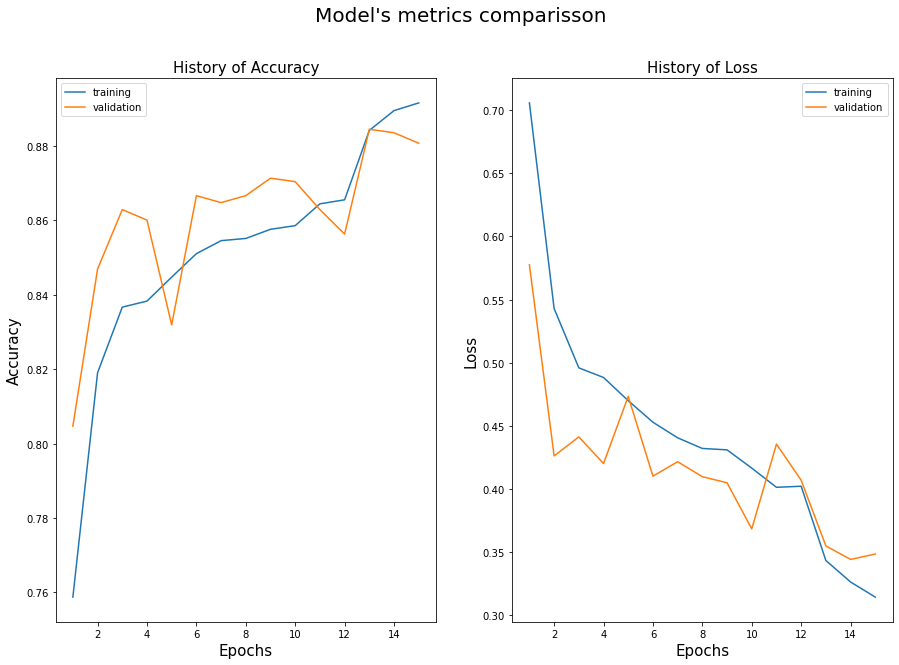

In [18]:
def trai_test_plot(acc, test_acc, loss, test_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle("Model's metrics comparisson", fontsize=20)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(test_acc) + 1), test_acc)
    ax1.set_title('History of Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(test_loss) + 1), test_loss)
    ax2.set_title('History of Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.show()
    

trai_test_plot(
    results.history['categorical_accuracy'],
    results.history['val_categorical_accuracy'],
    results.history['loss'],
    results.history['val_loss']
)

# 5. Submission 📝

In [19]:
final_model = keras.models.load_model('Cassava_model.h5')

In [20]:
TEST_DIR = '../input/cassava-leaf-disease-classification/test_images/'
test_images = os.listdir(TEST_DIR)
predictions = []

for image in test_images:
    img = Image.open(TEST_DIR + image)
    img = img.resize(size)
    img = np.expand_dims(img, axis=0)
    predictions.extend(final_model.predict(img).argmax(axis = 1))

In [21]:
predictions

[4]

In [22]:
sub = pd.DataFrame({'image_id': test_images, 'label': predictions})
display(sub)
sub.to_csv('submission.csv', index = False)

,image_id,label
0,2216849948.jpg,4
